In [1]:
# Install the necessary libraries
!pip install gdown

# Download the dataset zip file from Google Drive
!gdown --id 1Muvn7s13q0--kv2bIpPDh9M18QyY_OOP -O dataset.zip

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Muvn7s13q0--kv2bIpPDh9M18QyY_OOP
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 2.91G/2.91G [00:14<00:00, 197MB/s]


In [2]:
!unzip "/kaggle/working/dataset.zip"

Archive:  /kaggle/working/dataset.zip
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000001_000.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000001_001.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000001_002.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000002_000.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_000.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_001.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_002.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_003.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_004.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_005.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_006.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000003_007.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/00000004_000.png  
 extracting: Data_Pneumonia/PNEUMONIA_NEGATIVE (1)/0

In [3]:
import os
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split

# Define the directory paths for the positive and negative pneumonia images
pneumonia_positive_dir = '/kaggle/working/Data_Pneumonia/PNEUMONIA_POSITIVE'
pneumonia_negative_dir = '/kaggle/working/Data_Pneumonia/PNEUMONIA_NEGATIVE (1)'

# Define the image size
img_size = 224

# Create empty arrays to store the images and labels
images = []
labels = []

# Load the positive pneumonia images
for filename in os.listdir(pneumonia_positive_dir):
    img = cv2.imread(os.path.join(pneumonia_positive_dir, filename))
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(1)  # Positive label

# Load the negative pneumonia images
for filename in os.listdir(pneumonia_negative_dir):
    img = cv2.imread(os.path.join(pneumonia_negative_dir, filename))
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(0)  # Negative label

# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the dataset
random.seed(42)
idx = np.arange(len(images))
random.shuffle(idx)
images = images[idx]
labels = labels[idx]

# Divide the dataset into training, testing, and validation sets using an 80/10/10 split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=42, stratify=y_train)

# Print the size of each set
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 8000
Validation set size: 1000
Testing set size: 1000


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Create the training generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [5]:
#from keras.applications.resnet_v2 import ResNet50V2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

In [6]:
from tensorflow.keras import layers
from kerastuner import HyperParameters
import kerastuner as kt
from tensorflow.keras.applications import ResNet50V2

# Define the build function
def build_model(hp):
    img_size = 224
    resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Freeze the layers of the pre-trained models
    for layer in resnet_model.layers:
        layer.trainable = False

    # Define the top layers of the models with hyperparameters
    resnet_top_model = Sequential()
    resnet_top_model.add(layers.Flatten(input_shape=resnet_model.output_shape[1:]))
    for i in range(hp.Int('dense_layers', 1, 3)):
        resnet_top_model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        resnet_top_model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    resnet_top_model.add(layers.Dense(1, activation='sigmoid'))

    # Combine the models
    resnet_model_combined = Sequential()
    resnet_model_combined.add(resnet_model)
    resnet_model_combined.add(resnet_top_model)

    # Compile the models
    resnet_model_combined.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return resnet_model_combined

# Define the hyperparameters to tune
tuner_hp = HyperParameters()
tuner_hp.Int('dense_layers', 1, 3)
for i in range(3):
    tuner_hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
    tuner_hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)

# Instantiate the tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     hyperparameters=tuner_hp,
                     directory='tuner_dir',
                     project_name='resnet_tuner')

# Search for the best hyperparameters
tuner.search(train_generator, epochs=5, validation_data=(X_val, y_val))

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Use the best hyperparameters to build and train the model
resnet_model_tuned = build_model(best_hp)


Trial 10 Complete [00h 07m 59s]
val_accuracy: 0.5730000138282776

Best val_accuracy So Far: 0.5730000138282776
Total elapsed time: 00h 57m 38s


In [7]:
resnet_history_tuned = resnet_model_tuned.fit(train_generator, epochs=10, validation_data=(X_val, y_val))
resnet_score_tuned = resnet_model_tuned.evaluate(X_val, y_val, verbose=0)

Epoch 1/10
250/250 [==============================] - 101s 390ms/step - loss: 0.8179 - accuracy: 0.9064 - val_loss: 692.1395 - val_accuracy: 0.5730
Epoch 2/10
250/250 [==============================] - 96s 385ms/step - loss: 0.2095 - accuracy: 0.9314 - val_loss: 877.2502 - val_accuracy: 0.5730
Epoch 3/10
250/250 [==============================] - 98s 390ms/step - loss: 0.1769 - accuracy: 0.9408 - val_loss: 1293.5635 - val_accuracy: 0.5730
Epoch 4/10
250/250 [==============================] - 96s 382ms/step - loss: 0.1457 - accuracy: 0.9479 - val_loss: 1309.6155 - val_accuracy: 0.5730
Epoch 5/10
250/250 [==============================] - 93s 372ms/step - loss: 0.1590 - accuracy: 0.9344 - val_loss: 1776.4099 - val_accuracy: 0.5730
Epoch 6/10
250/250 [==============================] - 98s 391ms/step - loss: 0.1454 - accuracy: 0.9516 - val_loss: 1436.2383 - val_accuracy: 0.5730
Epoch 7/10
250/250 [==============================] - 97s 389ms/step - loss: 0.1307 - accuracy: 0.9516 - val_loss

In [8]:
resnet_model_tuned.save('ResNet50V2_model_tuned.h5')


In [9]:
print("ResNet-50V2 model results:")
print("Loss: ", resnet_score_tuned[0])
print("Accuracy: ", resnet_score_tuned[1])

ResNet-50V2 model results:
Loss:  1200.092529296875
Accuracy:  0.5730000138282776


In [10]:
resnet_score_tuned_test = resnet_model_tuned.evaluate(X_test, y_test, verbose=0)
print("ResNet-50V2 model results:")
print("Loss: ", resnet_score_tuned_test[0])
print("Accuracy: ", resnet_score_tuned_test[1])

ResNet-50V2 model results:
Loss:  1189.2305908203125
Accuracy:  0.5730000138282776


1.


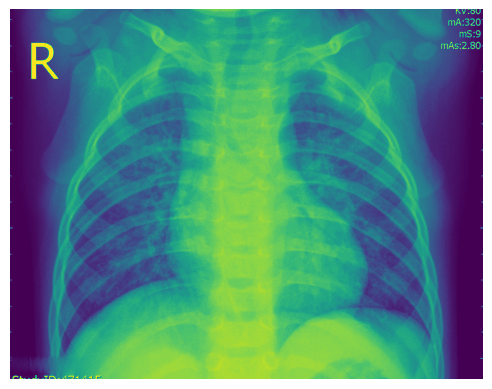

1/1 [==============================] - 2s 2s/step
The predicted class is: Negative

2.


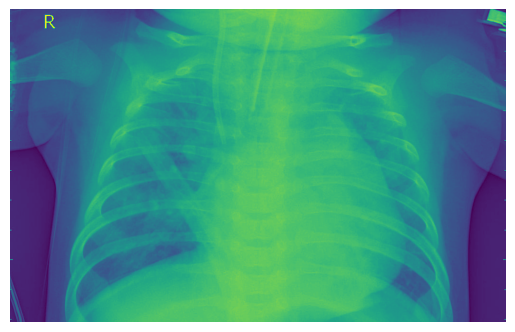

1/1 [==============================] - 0s 45ms/step
The predicted class is: Negative

3.


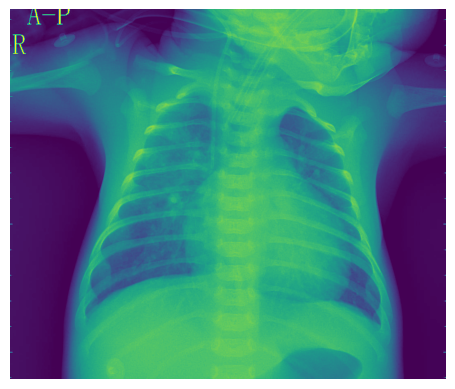

1/1 [==============================] - 0s 31ms/step
The predicted class is: Negative


In [15]:
import random
import matplotlib.pyplot as plt
import numpy as np

def random_image_prediction():
  # Get a list of all the file names in the directory
  import os
  #image_names = os.listdir('/kaggle/working/Data_Pneumonia/PNEUMONIA_POSITIVE')

  # Select a random image file
  #random_file = random.choice(image_names)

  # Load the image using the `load_img` function from the `PIL` library
  from PIL import Image
  image = Image.open('/kaggle/working/Data_Pneumonia/PNEUMONIA_POSITIVE/' + random_file)

  # Plot the image
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  # Preprocess the image for prediction
  # Preprocess the image
  image = image.resize((224, 224))
  image = image.convert('RGB')
  image = np.asarray(img)
  image = image / 255.0
  image = np.expand_dims(image, axis=0)

  # Get the prediction from the model
  prediction = resnet_model_tuned.predict(image)

  # Convert the prediction to the class label
  class_labels = ['Negative', 'Positive']
  predicted_label = class_labels[np.argmax(prediction[0])]

  print('The predicted class is:', predicted_label)

print('1.')
random_image_prediction()
print('')
print('2.')
random_image_prediction()
print('') 
print('3.')
random_image_prediction()

